In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
import seaborn as sns
from IPython.core.display_functions import display
from IPython.display import Audio
from livelossplot import PlotLossesKeras

import keras
from keras import layers
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator

from keras_preprocessing.image import img_to_array

import tensorflow as tf
from keras.layers import *

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
import numpy as np

In [2]:
files = os.listdir('data/spectrograms')
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

In [3]:
track_ids = []
print(files)
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

['73309.png', '32433.png', '127062.png', '131166.png', '14386.png', '66076.png', '30230.png', '67368.png', '143296.png', '73335.png', '122654.png', '122132.png', '71244.png', '43590.png', '126354.png', '25601.png', '71250.png', '124231.png', '38888.png', '132453.png', '126426.png', '75750.png', '55480.png', '117610.png', '129926.png', '112768.png', '115761.png', '12046.png', '129098.png', '12052.png', '113304.png', '115775.png', '99707.png', '133942.png', '58173.png', '19891.png', '75787.png', '80518.png', '45122.png', '118279.png', '134793.png', '51157.png', '10679.png', '116240.png', '42659.png', '81612.png', '62589.png', '96408.png', '116526.png', '122683.png', '28480.png', '21895.png', '30740.png', '109189.png', '118084.png', '13199.png', '127274.png', '108297.png', '72215.png', '132679.png', '70402.png', '93941.png', '76073.png', '133567.png', '17499.png', '144937.png', '123760.png', '133573.png', '137715.png', '43962.png', '11942.png', '122456.png', '65755.png', '141873.png', '73

  0%|          | 0/7847 [00:00<?, ?it/s]

In [4]:
filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]
filtered_tracks

track_id
73309             Rock
32433       Electronic
127062            Folk
131166            Rock
14386          Hip-Hop
              ...     
139537    Instrumental
83791             Rock
122671    Instrumental
67365              Pop
71507       Electronic
Name: genre_top, Length: 7847, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [5]:
genres = {}
tmp_x = 0
#Assign value for the genres
#for i in genres_df[genres_df['parent']==0]['title'].unique():
for i in filtered_tracks.unique():
    genres[i] = tmp_x
    tmp_x = tmp_x + 1

print(genres)
genres_df[genres_df['parent']==0]

{'Rock': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'Pop': 4, 'Instrumental': 5, 'Experimental': 6, 'International': 7}


,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


In [6]:
#Split dataset into chunks
train_ds = filtered_tracks.sample(frac = 0.8)

tmp_ds = filtered_tracks.drop(train_ds.index)
validation_ds = tmp_ds.sample(frac = 0.5)
test_ds = tmp_ds.drop(validation_ds.index)

print(f"Training has {len(train_ds)}, Validation has {len(validation_ds)}, Testing has {len(test_ds)}")

Training has 6278, Validation has 784, Testing has 785


In [7]:
import keras

tf_train_data = pd.DataFrame(columns=['Filename', 'label'])
tf_validation_data = pd.DataFrame(columns=['Filename', 'label'])
tf_test_data = pd.DataFrame(columns=['Filename', 'label'])
for i in tqdm(train_ds.index):
    tf_train_data.loc[i]=["data/spectrograms/" + str(i) + ".png", genres[train_ds.loc[i]]]

for i in tqdm(validation_ds.index):
    tf_validation_data.loc[i]=["data/spectrograms/" + str(i) + ".png", genres[validation_ds.loc[i]]]

for i in tqdm(test_ds.index):
    tf_test_data.loc[i]=["data/spectrograms/" + str(i) + ".png", genres[test_ds.loc[i]]]
#genres[test_ds.loc[i]]]

  0%|          | 0/6278 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

In [ ]:
tf_validation_data

In [ ]:
#tf_train_data = pd.DataFrame({'image': training_data, 'label': training_labels}, columns=['image', 'label'])
tf_train_data.loc[2]
#filtered_tracks.loc[2]
#genres['Hip-Hop']

In [8]:
train_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=False,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=0,
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

validation_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=False,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=0,
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

test_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    rotation_range=0
)

BATCH_SIZE = 32
print(list(genres.keys()))

traingen = train_generator.flow_from_dataframe(tf_train_data,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               subset='training',
                                               shuffle=True,
                                               batch_size=BATCH_SIZE,
                                               target_size=(174,484),
                                               seed=42)

validationgen = validation_generator.flow_from_dataframe(tf_validation_data,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                                         target_size=(174,484),
                                               seed=42)

testgen = test_generator.flow_from_dataframe(tf_test_data,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               subset='training',
                                               shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             target_size=(174,484),
                                               seed=42)

['Rock', 'Electronic', 'Folk', 'Hip-Hop', 'Pop', 'Instrumental', 'Experimental', 'International']
Found 6278 validated image filenames.
Found 784 validated image filenames.
Found 785 validated image filenames.


In [18]:
import keras_tuner as kt

def model2hp(hp):
    md = keras.Sequential()
    md.add(keras.Input(shape=(174, 484, 3)))
    hp_size = hp.Int('size', min_value=128, max_value=512, step=128)
    md.add(layers.Resizing(hp_size, hp_size))

    md.add(layers.Conv2D(64, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Conv2D(64, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Conv2D(128, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Conv2D(128, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Flatten())
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    md.add(layers.Dense(hp_units1, activation='relu'))

    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)
    md.add(layers.Dropout(hp_dropout1))
    md.add(layers.Dense(8, activation="softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    md.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return md

tuner = kt.Hyperband(model2hp,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir_2',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(validationgen, validation_data=validationgen, epochs=50, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Units: {best_hps.get('units1')}
Dropout:{best_hps.get('dropout1')}
Learning Rate: {best_hps.get('learning_rate')}
Size: {best_hps.get('size')}
""")

Trial 10 Complete [00h 00m 41s]
val_accuracy: 0.1428571343421936

Best val_accuracy So Far: 0.1517857164144516
Total elapsed time: 00h 09m 16s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
256               |256               |size
64                |384               |units1
0.2               |0.5               |dropout1
0.01              |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2022-06-21 16:13:43.345268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 27.7887 - accuracy: 0.1224

2022-06-21 16:13:54.352015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 21s 813ms/step - loss: 27.7887 - accuracy: 0.1224 - val_loss: 306.9490 - val_accuracy: 0.1097
Epoch 2/2
21/25 [========================>.....] - ETA: 1s - loss: 3.1430 - accuracy: 0.1143

KeyboardInterrupt: 

In [ ]:
def model2(width, height, depth, classes):
    return keras.Sequential([
        keras.Input(shape=(height, width, depth)),
        layers.Resizing(128, 128),

        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        # Adding this layer
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(classes, activation="softmax")
    ])
model = model2(
    width=484, height=174,
    depth=3, classes=len(genres))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

In [70]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [118]:
new_input = Input(shape=(174,484,3))
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=new_input)
#base_model = VGG16(weights="imagenet", include_top=False)
base_model.trainable = False ## Not trainable weights

In [ ]:
from keras import Model
from keras.models import Sequential

def create_model(input_shape, n_classes, fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    md = Model(inputs=conv_base.input, outputs=output_layer)

    return md

model_vgg = create_model((174,484,3), 8)

#print("==============BASE MODEL==============")
#print(base_model.summary())
print("==============NEW MODEL===============")
print(model_vgg.summary())

model_vgg.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [16]:
import keras_tuner as kt
from keras.applications.vgg16 import VGG16
from keras import Model

def create_model_kt(hp):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=(174,484,3))

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    hp_fine_tune = hp.Int('included_layers', min_value=0, max_value=10, step=1)
    if hp_fine_tune > 0:
        for layer in conv_base.layers[:-hp_fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)

    hp_units1 = hp.Int('units1', min_value=100, max_value=4096, step=100)
    top_model = Dense(hp_units1, activation='relu')(top_model)
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)
    top_model = Dropout(hp_dropout1)(top_model)

    hp_units2 = hp.Int('units2', min_value=100, max_value=1000, step=100)
    top_model = Dense(hp_units2, activation='relu')(top_model)
    hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
    top_model = Dropout(hp_dropout2)(top_model)

    output_layer = Dense(8, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    md = Model(inputs=conv_base.input, outputs=output_layer)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    md.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return md


tuner = kt.Hyperband(create_model_kt,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_vgg',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(validationgen, validation_data=validationgen, epochs=10, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Included: {best_hps.get('included_layers')}
Units1: {best_hps.get('units1')}
Dropout1:{best_hps.get('dropout1')}
Units2: {best_hps.get('units2')}
Dropout2:{best_hps.get('dropout2')}
Learning Rate: {best_hps.get('learning_rate')}
Size: {best_hps.get('size')}
""")

model_spec = tuner.hypermodel.build(best_hps)
print(model_spec.summary())
keras.utils.plot_model(model_spec, show_shapes=True)

INFO:tensorflow:Reloading Oracle from existing project my_dir_vgg/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir_vgg/intro_to_kt/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |0                 |included_layers
2300              |3200              |units1
0.8               |0.2               |dropout1
900               |200               |units2
0.2               |0.4               |dropout2
0.001             |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



2022-06-25 09:57:52.686233: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_14 in the registry.
Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_14 in the registry.


2022-06-25 09:57:52.686353: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_14 in the registry.
Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueErro

Epoch 1/2


2022-06-25 09:57:53.670861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 4.2749 - accuracy: 0.1033

2022-06-25 09:58:15.478674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

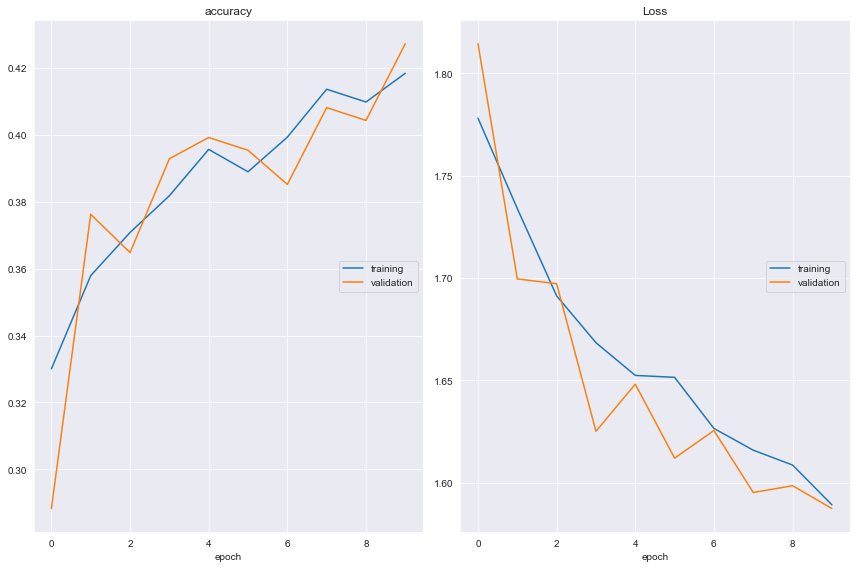

accuracy
	training         	 (min:    0.330, max:    0.418, cur:    0.418)
	validation       	 (min:    0.288, max:    0.427, cur:    0.427)
Loss
	training         	 (min:    1.589, max:    1.778, cur:    1.589)
	validation       	 (min:    1.587, max:    1.815, cur:    1.587)
197/197 [==============================] - 109s 549ms/step - loss: 1.5892 - accuracy: 0.4184 - val_loss: 1.5874 - val_accuracy: 0.4273


In [190]:
history = model_vgg.fit(traingen, validation_data=validationgen, epochs=10, batch_size=64, callbacks=[early_stop, PlotLossesKeras()])

In [201]:
import sklearn.metrics

image = tf.keras.preprocessing.image.load_img("dataset/Rock/87121.png")
image = img_to_array(image)
grr = [image]

image = tf.keras.preprocessing.image.load_img("dataset/Electronic/20667.png")
image = img_to_array(image)
grr.append(image)

grr = np.array(grr, dtype="float") / 255.0

print(genres)

prediction = model_vgg.predict(grr)

display(Audio('data/tracks_wav//020667.wav', rate=22500))
pd.DataFrame(prediction, columns=list(genres.keys()))

{'Rock': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'Pop': 4, 'Instrumental': 5, 'Experimental': 6, 'International': 7}
1/1 [==============================] - 0s 11ms/step


,Rock,Electronic,Folk,Hip-Hop,Pop,Instrumental,Experimental,International
0,0.13034,0.101387,0.186856,0.043590,0.189422,0.144465,0.104617,0.099323
1,0.08053,0.214307,0.062525,0.173268,0.130814,0.118863,0.109640,0.110053


In [204]:
pred = model_vgg.predict(testgen)


25/25 [==============================] - 10s 428ms/step


<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[14, 18,  8,  8,  3, 14, 12, 16],
       [ 9, 20,  9, 12,  4, 17,  9, 18],
       [11, 18,  9,  8,  4, 17, 13, 14],
       [12, 20, 13,  8,  4, 22, 12, 18],
       [16, 25,  4, 11,  1, 24,  6,  8],
       [ 9, 28, 10, 15,  3, 25, 10, 18],
       [15, 12, 11,  3,  3, 16,  6,  8],
       [14, 22,  8, 11,  5, 21, 10, 13]], dtype=int32)>

In [210]:
from sklearn.metrics import confusion_matrix
import math


number_of_examples = len(testgen.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE))
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(testgen[i][1]))
cm = confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix

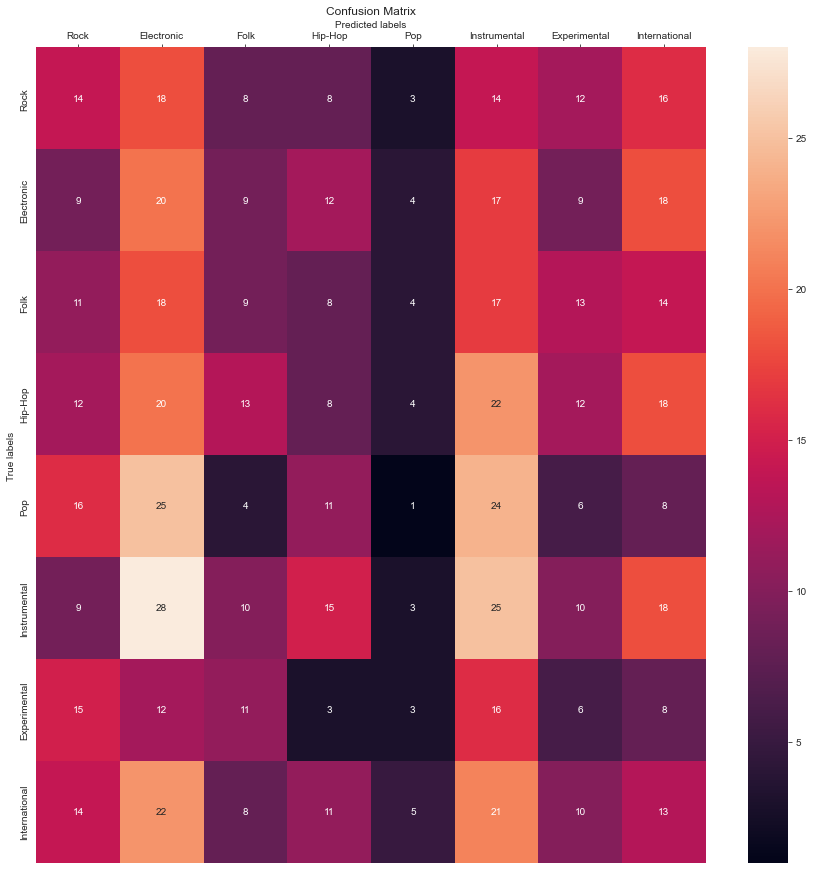

In [214]:
import seaborn as sns

f = plt.figure(figsize=(15,15))
ax= f.add_subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.xaxis.set_label_position('top')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(list(genres.keys()))
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticklabels(list(genres.keys()));

In [10]:
tf_train_data_chroma = pd.DataFrame(columns=['Filename', 'label'])
tf_validation_data_chroma = pd.DataFrame(columns=['Filename', 'label'])
tf_test_data_chroma = pd.DataFrame(columns=['Filename', 'label'])
for i in tqdm(train_ds.index):
    tf_train_data_chroma.loc[i]=["data/chroma/" + str(i) + ".png", genres[train_ds.loc[i]]]

for i in tqdm(validation_ds.index):
    tf_validation_data_chroma.loc[i]=["data/chroma//" + str(i) + ".png", genres[validation_ds.loc[i]]]

for i in tqdm(test_ds.index):
    tf_test_data_chroma.loc[i]=["data/chroma//" + str(i) + ".png", genres[test_ds.loc[i]]]

  0%|          | 0/6278 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

In [11]:
generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=False,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=0,
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

genX1 = generator.flow_from_dataframe(tf_train_data,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(174,484),
                                               seed=42)
genX2 = generator.flow_from_dataframe(tf_train_data_chroma,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(174,484),
                                               seed=42)

genX1val = generator.flow_from_dataframe(tf_validation_data,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(174,484),
                                               seed=42)
genX2val = generator.flow_from_dataframe(tf_validation_data_chroma,class_mode='raw',
                                               x_col='Filename',
                                               y_col = 'label',
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(174,484),
                                               seed=42)

def format_gen_outputs(gen1,gen2):
    x1 = gen1[0]
    x2 = gen2[0]
    y1 = gen1[1]
    return [x1, x2], y1

traingen2 = map(format_gen_outputs, genX1, genX2)
validationgen2 = map(format_gen_outputs, genX1val, genX2val)


Found 6278 validated image filenames.
Found 6278 validated image filenames.
Found 784 validated image filenames.
Found 784 validated image filenames.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 174, 484, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 174, 484, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_4 (Resizing)          (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                            

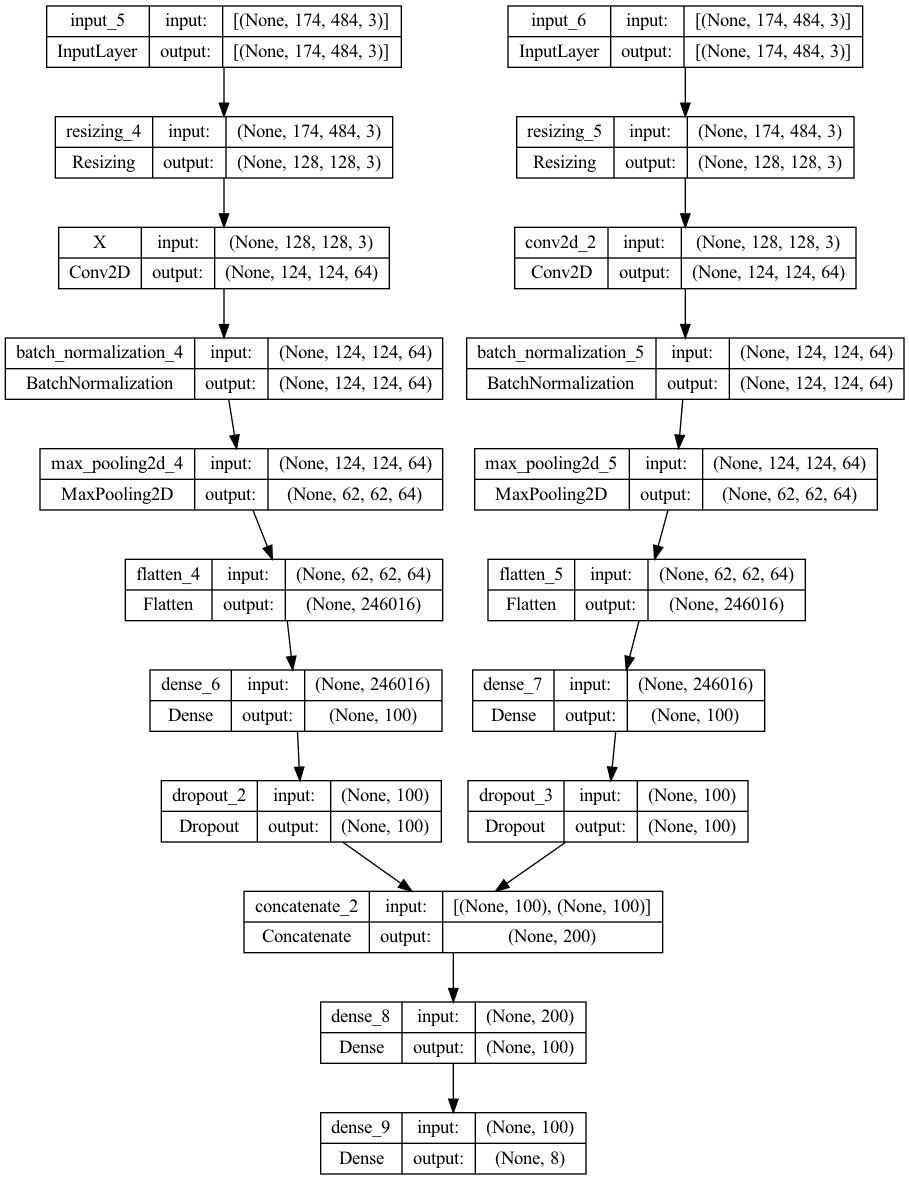

In [34]:
from keras import Model

def create_multiinput_model(width, height, depth, classes):
    inputA = Input(shape=(height,width,depth))
    inputB = Input(shape=(height,width,depth))

    # the first branch operates on the first input
    x = Resizing(128, 128)(inputA)

    x = Conv2D(64, kernel_size=(5, 5), activation="relu", name="X")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(100)(x)
    x = Dropout(0.2)(x)

    x = Model(inputs=inputA, outputs=x)
    # the second branch opreates on the second input
    y = Resizing(128, 128)(inputB)

    y = Conv2D(64, kernel_size=(5, 5), activation="relu")(y)
    y = BatchNormalization()(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)

    y = Flatten()(y)
    y = Dense(100)(y)
    y = Dropout(0.2)(y)
    y = Model(inputs=inputB, outputs=y)
    # combine the output of the two branches
    combined = concatenate([x.output, y.output])
    # apply a FC layer and then a regression prediction on the
    # combined outputs
    z = Dense(100)(combined)
    z = Dense(classes, activation="softmax")(z)
    # our model will accept the inputs of the two branches and
    # then output a single value
    md = Model(inputs=[x.input, y.input], outputs=z)

    return md

multi_model = create_multiinput_model(484, 174, 3, 8)

multi_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(multi_model.summary())
keras.utils.plot_model(multi_model, show_shapes=True)

In [13]:
import keras_tuner as kt
from keras.applications.vgg16 import VGG16
from keras import Model

def create_multi_model_kt(hp):
    inputA = Input(shape=(484, 174, 3))
    inputB = Input(shape=(484, 174, 3))

    hp_size = hp.Int('size', min_value=128, max_value=512, step=128)

    # the first branch operates on the first input
    x = Resizing(hp_size, hp_size)(inputA)

    x = Conv2D(64, kernel_size=(5, 5), activation="relu", name="X")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    hp_units_x= hp.Int('units_x', min_value=10, max_value=100, step=10)
    x = Dense(hp_units_x)(x)

    hp_dropout_x = hp.Float('dropout_x', min_value=0.1, max_value=0.9, step=0.1)
    x = Dropout(hp_dropout_x)(x)

    x = Model(inputs=inputA, outputs=x)
    # the second branch opreates on the second input
    y = Resizing(hp_size, hp_size)(inputB)

    y = Conv2D(64, kernel_size=(5, 5), activation="relu")(y)
    y = BatchNormalization()(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)

    y = Flatten()(y)
    hp_units_y= hp.Int('units_y', min_value=10, max_value=100, step=10)
    y = Dense(hp_units_y)(y)
    hp_dropout_y = hp.Float('dropout_y', min_value=0.1, max_value=0.9, step=0.1)
    y = Dropout(hp_dropout_y)(y)
    y = Model(inputs=inputB, outputs=y)
    # combine the output of the two branches
    combined = concatenate([x.output, y.output])
    # apply a FC layer and then a regression prediction on the
    # combined outputs
    hp_units_z= hp.Int('units_z', min_value=10, max_value=100, step=10)
    z = Dense(hp_units_z)(combined)
    z = Dense(8, activation="softmax")(z)
    # our model will accept the inputs of the two branches and
    # then output a single value
    md = Model(inputs=[x.input, y.input], outputs=z)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    md.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return md


tuner = kt.Hyperband(create_multi_model_kt,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_multi',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(validationgen2, validation_data=validationgen2, epochs=10, callbacks=[stop_early], steps_per_epoch=len(tf_train_data)//BATCH_SIZE, validation_steps=len(tf_validation_data)//BATCH_SIZE)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
UnitsX: {best_hps.get('units_x')}
DropoutX:{best_hps.get('dropout_x')}
UnitsY: {best_hps.get('units_y')}
DropoutY:{best_hps.get('dropout_y')}
UnitsZ: {best_hps.get('units_z')}
Learning Rate: {best_hps.get('learning_rate')}
Size: {best_hps.get('size')}
""")

multi_model_spec = tuner.hypermodel.build(best_hps)
print(multi_model_spec.summary())
keras.utils.plot_model(multi_model_spec, show_shapes=True)

INFO:tensorflow:Reloading Oracle from existing project my_dir_multi/intro_to_kt/oracle.json

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |?                 |size
40                |?                 |units_x
0.3               |?                 |dropout_x
100               |?                 |units_y
0.4               |?                 |dropout_y
80                |?                 |units_z
0.0001            |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2


2022-06-26 09:53:44.511872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/196 [>.............................] - ETA: 4:22 - loss: 103.6135 - accuracy: 0.1250

KeyboardInterrupt: 

In [12]:
validationgen2.__next__()

Found 784 validated image filenames.
Found 784 validated image filenames.


([array([[[[0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           ...,
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ]],
  
          [[0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           ...,
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ]],
  
          [[0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           ...,
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ],
           [0.5764706 , 0.5764706 , 0.5764706 ]],
  
          ...,
  
          [[0.5764706 , 0.5764706 , 0.57

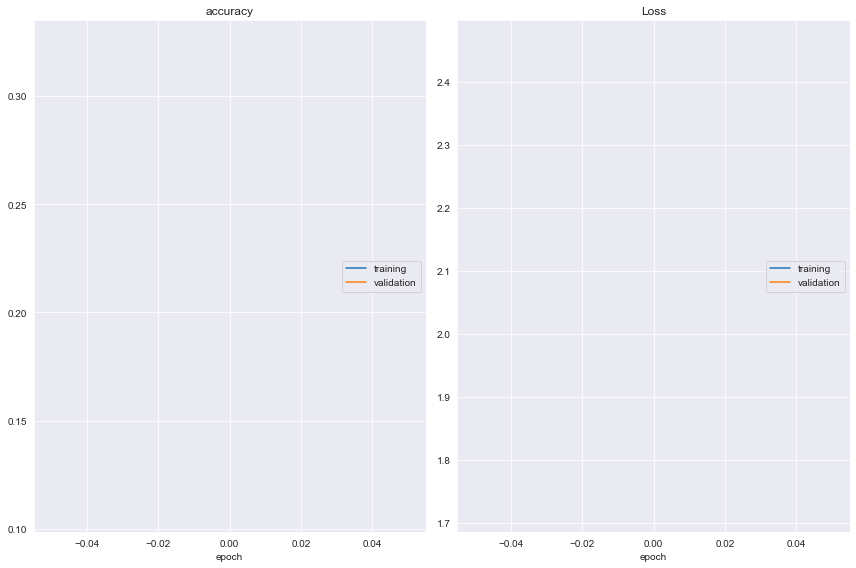

accuracy
	training         	 (min:    0.324, max:    0.324, cur:    0.324)
	validation       	 (min:    0.109, max:    0.109, cur:    0.109)
Loss
	training         	 (min:    1.723, max:    1.723, cur:    1.723)
	validation       	 (min:    2.461, max:    2.461, cur:    2.461)
2/2 [==============================] - 12s 12s/step - loss: 1.7229 - accuracy: 0.3242 - val_loss: 2.4609 - val_accuracy: 0.1094
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.7740 - accuracy: 0.3398

KeyboardInterrupt: 

In [45]:
#history = multi_model.fit_generator(traingen2, epochs=1, steps_per_epoch=1, validation_steps=2)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = multi_model.fit(traingen2, epochs=10, validation_data=validationgen2, steps_per_epoch=len(tf_train_data)//BATCH_SIZE, validation_steps=len(tf_validation_data)//BATCH_SIZE, callbacks=[early_stop, PlotLossesKeras()])

In [40]:
multi_model.evaluate(validationgen2, steps=25)

 2/25 [=>............................] - ETA: 1:05 - loss: 2.3518 - accuracy: 0.1094

KeyboardInterrupt: 